In [313]:
import numpy as np
import pandas as pd
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from econml.metalearners import SLearner, TLearner
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML, NonParamDML
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error 
import shap

Define Necessary Functions

In [314]:
#Split into train and test set
def get_split(simulation: pd.DataFrame) -> np.ndarray:
    
    train_df, test_df = train_test_split(simulation, test_size=0.5, random_state=42)

    # Extract features and target variables for training
    X_train = train_df[[col for col in simulation.columns if col.startswith('X')]].to_numpy()
    T_train = train_df['T'].to_numpy()
    Y_train = train_df['y'].to_numpy()

    # Extract features and true CATE for testing
    X_test = test_df[[col for col in simulation.columns if col.startswith('X')]].to_numpy()
    T_test = test_df['T'].to_numpy()
    y_test = test_df['y'].to_numpy()

    true_cate_test = test_df['CATE'].to_numpy()

    return train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_test

In [315]:
def vis_treatment_eff(simulation: pd.DataFrame):
    sorted_cate = simulation[simulation['T'] == 1]
    sorted_cate = sorted_cate.sort_values(by=['CATE'])
    sorted_cate = sorted_cate[['CATE']]

    x = np.linspace(0, len(sorted_cate), num=len(sorted_cate))
    plt.scatter(x, sorted_cate, alpha=0.5)
    #plt.plot(x, sorted_cate, color='red')
    plt.xlabel('Observations')
    plt.ylabel('Treatment Effects')

In [316]:
def plot_predict_cate_corr(est_cate: np.array, true_cate_test: np.array):
    
    plt.figure(figsize=(8, 8))
    plt.scatter(est_cate, true_cate_test, alpha=0.5)    
    plt.plot([min(true_cate_test), max(true_cate_test)], [min(true_cate_test), max(true_cate_test)], '--', color='red')
    plt.xlabel('Estimated CATE')
    plt.ylabel('True CATE')
    plt.grid(True)
    plt.show()

    est_cate=est_cate.reshape(-1, 1)
    reg = LinearRegression().fit(est_cate, true_cate_test)
    print(f'Correlation between true and predicted CATE: {reg.score(est_cate, true_cate_test)}')

Create Simulations

In [317]:
#Create simulations

sim_dict = {}
i = 1

for p in [10, 20, 30, 50]:
    for n in [5000, 7000, 10000]:
        sim: SimulationStudy = SimulationStudy(p=p, mean_correlation=0.5, cor_variance=0.01, n=n, geom=True)
        simulation = sim.create_dataset()


        key = f'Simulation_{p}_{n}'
        value = simulation

        sim_dict[key]= value
        i += 1


In [318]:
#Split df into train and test data

splits_dict = {}

for key, value in sim_dict.items():

    train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_test = get_split(value)
    
    temp_dict = {'train_df': train_df, 'test_df': test_df, 
                   'X_train': X_train, 'Y_train': Y_train, 
                   'T_train': T_train, 'X_test': X_test, 
                   'T_test': T_test, 'y_test': y_test, 
                   'true_cate_test': true_cate_test}

        
    splits_dict[key] = temp_dict



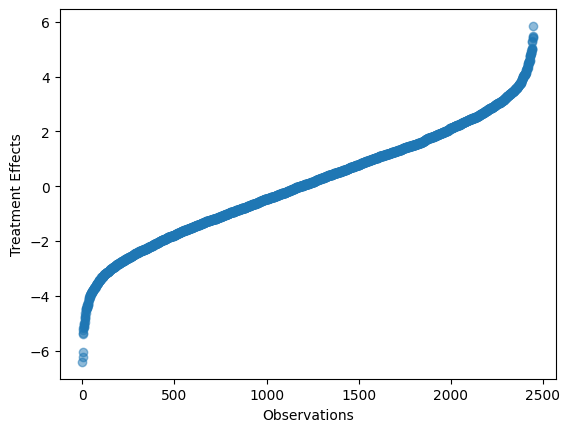

In [319]:
#Visualize Treatment Effects for ordered observations
vis_treatment_eff(sim_dict['Simulation_10_5000'])

OLS Model

In [320]:
#Create OLS model
#ols = LinearRegression()

In [321]:
#Estimate a fully feature-treatment interacted model
#interaction_term = X_train_1 * T_train_1
#X_train_ols = np.hstack([X_train_1, T_train_1, interaction_term])
#ols.fit(X_train_ols, Y_train_1)

#interaction_term_test = X_test_1 * T_test_1
#X_test_ols = np.hstack([X_test_1, T_test_1, interaction_term_test])
#est_error = (y_test_1 - ols.predict(X_test_ols))**2

In [322]:
#Cannot currently estimate CATE functions from OLS to compare with true CATEs
#Treatment and control groups have different sizes

#interaction_term_test = X_test_1 * T_test_1
#X_test_ols = np.hstack([X_test_1, T_test_1, interaction_term_test])

#treatment_col_index = sim_1.p

# Generate treatment and control groups
#treatment_group = X_test_ols[X_test_ols[:, treatment_col_index] == 1]
#control_group = X_test_ols[X_test_ols[:, treatment_col_index] == 0]

# Predict outcomes
#pred_treatment = ols.predict(treatment_group)
#pred_control = ols.predict(control_group)

In [323]:
#plt.figure(figsize=(8, 8))
#plt.scatter(est_error, true_cate_test_1, alpha=0.5, label='OLS')
#plt.plot([min(true_cate_test_1), max(true_cate_test_1)], [min(true_cate_test_1), max(true_cate_test_1)], '--', color='red')
#plt.xlabel('OLS MSE')
#plt.ylabel('True CATE')
#plt.title('Estimated vs. True CATE')
#plt.legend()
#plt.grid(True)
#plt.show()

In [324]:
#estimated_cate_ols=estimated_cate_ols.reshape(-1, 1)
#true_cate_test=true_cate_test_1.reshape(-1,1)
#reg = LinearRegression().fit(estimated_cate_ols, true_cate_test)
#reg.score(estimated_cate_ols, true_cate_test)

S-Learner

In [325]:
#s_learner = SLearner(overall_model=RandomForestRegressor())  
#s_learner_model = s_learner.fit(Y=Y_train_1, T=T_train_1, X=X_train_1)
#pred_cate_s = s_learner_model.effect(X_test_1)
#plot_predict_cate_corr(pred_cate_s, true_cate_test_1)

T-Learner

In [326]:
def TLearner_estimator(Y_train, T_train, X_train, X_test, true_cate_test):

    est_t = TLearner(models=RandomForestRegressor())
    est_t.fit(Y=Y_train, T=T_train, X=X_train)
    estimated_cate_t = est_t.effect(X_test)
    T_MSE = mean_squared_error(true_cate_test, estimated_cate_t)

    return estimated_cate_t, T_MSE

estimated_cate_t, T_MSE = TLearner_estimator(splits_dict['Simulation_10_5000']['Y_train'], splits_dict['Simulation_10_5000']['T_train'], 
                                             splits_dict['Simulation_10_5000']['X_train'], splits_dict['Simulation_10_5000']['X_test'],
                                             splits_dict['Simulation_10_5000']['true_cate_test'])



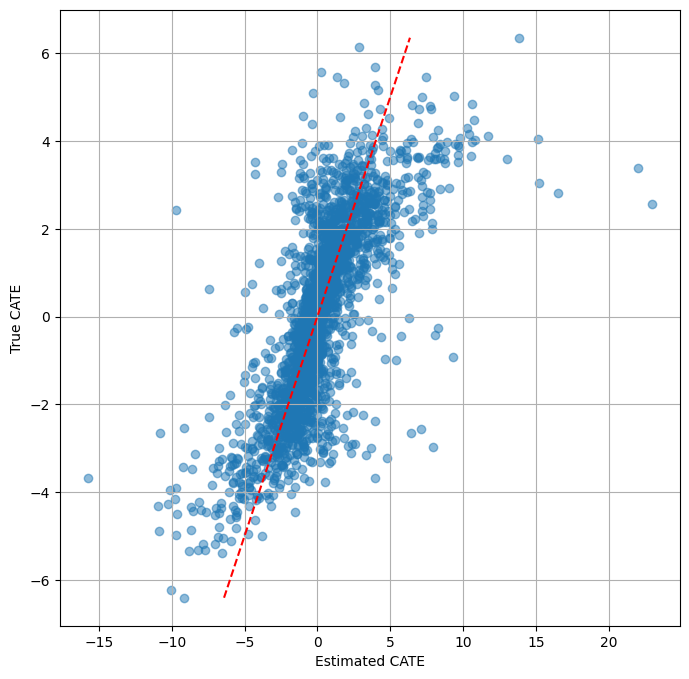

Correlation between true and predicted CATE: 0.5299943502722624


In [327]:
plot_predict_cate_corr(estimated_cate_t, splits_dict['Simulation_10_5000']['true_cate_test'])

Causal Forest DML

In [328]:
def CF_DML(Y_train, T_train, X_train, y_test, X_test, T_test):

#Estimate the causal forest model
    est_cfdml = CausalForestDML(model_y='auto',
                        model_t=DummyClassifier(),
                        discrete_treatment=True,
                        cv=5,
                        n_estimators=1000,
                        random_state=42,
                        criterion='mse',
                        honest=True)

    est_cfdml.fit(Y=Y_train, T=T_train, X=X_train, W=None, cache_values=True)
    estimated_cate = est_cfdml.effect(X_test)
    mse = est_cfdml.score(Y=y_test, X=X_test, T=T_test, W=None)
    
    return estimated_cate, mse

estimated_cate_dml, cf_dml_MSE = CF_DML(splits_dict['Simulation_10_5000']['Y_train'], splits_dict['Simulation_10_5000']['T_train'], 
                                       splits_dict['Simulation_10_5000']['X_train'], splits_dict['Simulation_10_5000']['y_test'],
                                       splits_dict['Simulation_10_5000']['X_test'], splits_dict['Simulation_10_5000']['T_test'])



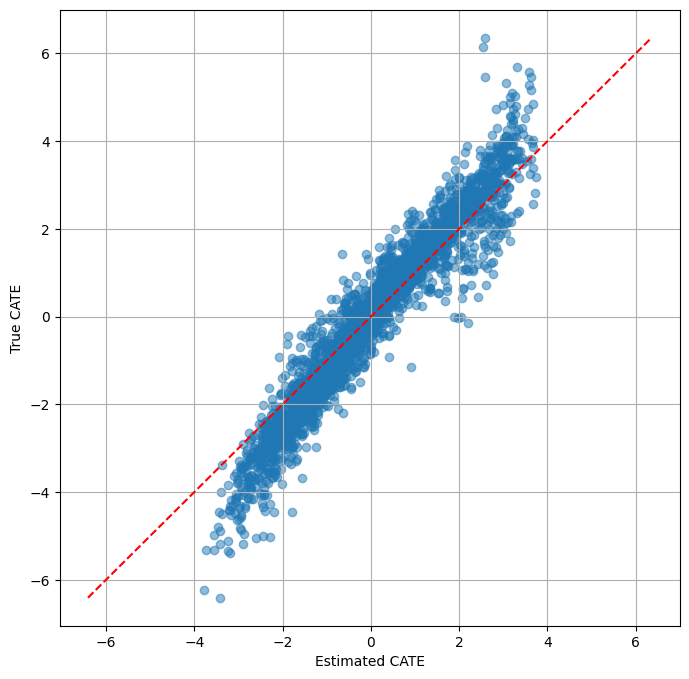

Correlation between true and predicted CATE: 0.9234331965628579


In [329]:
plot_predict_cate_corr(estimated_cate_dml, splits_dict['Simulation_10_5000']['true_cate_test'])

Non-Parametric DML

In [330]:
def non_param_dml(Y_train, T_train, X_train, y_test, X_test, T_test):

    est_npm = NonParamDML(
        model_y='auto',
        model_t=DummyClassifier(),
        model_final=GradientBoostingRegressor(),
        cv = 5,
        random_state = 42,
        discrete_treatment=True,
    )
    
    est_npm.fit(Y=Y_train, T=T_train, X=X_train, W=None, cache_values=True)
    estimated_cate = est_npm.effect(X_test)
    mse = est_npm.score(Y=y_test, X=X_test, T=T_test, W=None)

    return estimated_cate, mse

estimated_cate_non_param, non_param_MSE = non_param_dml(splits_dict['Simulation_10_5000']['Y_train'], splits_dict['Simulation_10_5000']['T_train'], 
                                       splits_dict['Simulation_10_5000']['X_train'], splits_dict['Simulation_10_5000']['y_test'],
                                       splits_dict['Simulation_10_5000']['X_test'], splits_dict['Simulation_10_5000']['T_test'])



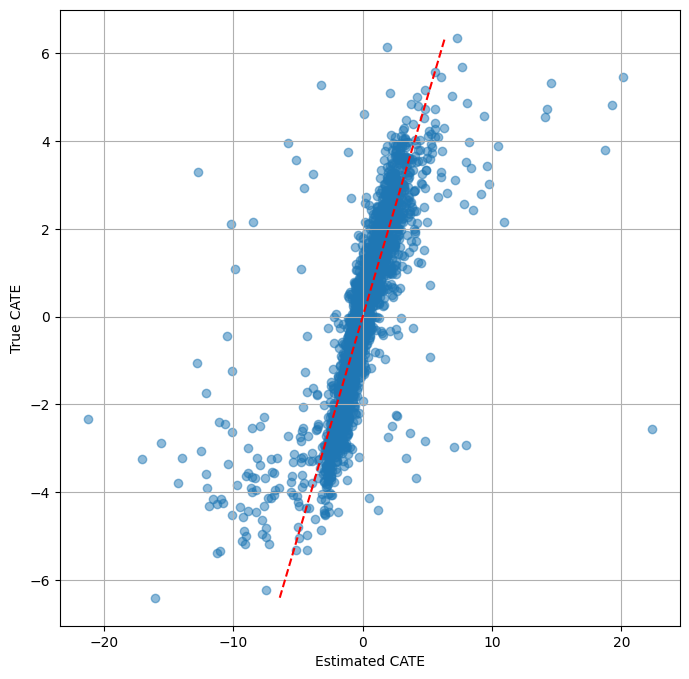

Correlation between true and predicted CATE: 0.5659213033004609


In [331]:
plot_predict_cate_corr(estimated_cate_non_param, splits_dict['Simulation_10_5000']['true_cate_test'])

In [332]:
print(f'MSE T-Learner: {T_MSE}')
print(f'MSE Double ML: {cf_dml_MSE}')
print(f'MSE Non-Parametric Double ML: {non_param_MSE}')

MSE T-Learner: 3.9280798394287353
MSE Double ML: 8.37073280306958
MSE Non-Parametric Double ML: 9.081421468498473
